In [1]:
# do not forget to swapoff -a
import numpy as np       # linear algebra
import pylab as pl       # plots
import tensorflow as tf  # just for data sets (no deep learning yet)

In [2]:
# choose wisely
(train, label_train), (test, label_test) = tf.keras.datasets.mnist.load_data()
(train, label_train), (test, label_test) = tf.keras.datasets.fashion_mnist.load_data()

# make sure your data is floating point
test = test.astype(np.float32)
train = train.astype(np.float32)

# print shapes
print(train.shape, label_train.shape)
print(test.shape, label_test.shape)

((60000, 28, 28), (60000,))
((10000, 28, 28), (10000,))


In [3]:
# here we can subsample in the data set
num_test, num_train = 10000, 60000
test, label_test = test[:num_test], label_test[:num_test]
train, label_train = train[:num_train], label_train[:num_train]

# print shapes
print(train.shape, label_train.shape)
print(test.shape, label_test.shape)

((60000, 28, 28), (60000,))
((10000, 28, 28), (10000,))


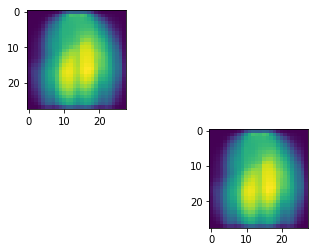

In [4]:
# let us have a look at the mean image
pl.subplot(221)
mu_test = np.mean(test, axis=0)
pl.imshow(mu_test)
pl.subplot(224)
mu_train = np.mean(train, axis=0)
pl.imshow(mu_train)
pl.show()

In [5]:
# let's forget about the dimension of the images
test_flatten = test.reshape((-1, 784))
train_flatten = train.reshape((-1, 784))

# print shapes
print(train_flatten.shape, test_flatten.shape)


((60000, 784), (10000, 784))


In [6]:
def center_data(data):
    mu = np.expand_dims(np.mean(data, axis=0),0)
    print("broadcasting works well", data.shape, mu.shape)
    return data-mu

In [7]:
train_centered = center_data(train_flatten)
test_centered = center_data(test_flatten)

print(np.sum(np.square(np.mean(train_centered, axis=0))))
print(np.sum(np.square(np.mean(test_centered, axis=0))))

('broadcasting works well', (60000, 784), (1, 784))
('broadcasting works well', (10000, 784), (1, 784))
4.942781e-06
8.3710484e-07


In [8]:
import time

In [9]:
begin = time.time()
Cov = np.tensordot(train_centered, train_centered, axes=((0,), (0,)))
print(Cov.shape, time.time()-begin)

((784, 784), 0.2631349563598633)


In [10]:
begin = time.time()
Cov = train_centered.T.dot(train_centered)
print(Cov.shape, time.time()-begin)

((784, 784), 0.319943904876709)


In [11]:
begin = time.time()
# C = U D Ut
eigvals, eigvecs = np.linalg.eigh(Cov)
print(time.time()-begin)

0.249662160873


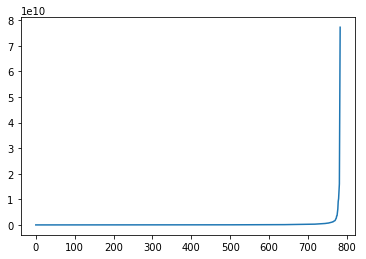

In [12]:
# have a look at the spectrum
pl.plot(eigvals)

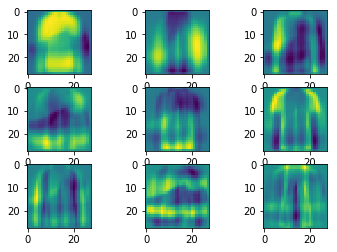

In [13]:
k = 9
for i in range(k):
    vector = eigvecs[:,-i-1]
    pl.subplot(3, 3, i+1)
    pl.imshow(vector.reshape((28, 28)))

In [14]:
k = 78
base = eigvecs[:,-k:]
print(base.shape, train_flatten.shape)

((784, 78), (60000, 784))


In [15]:
PCA_features = train_centered.dot(base)
print(PCA_features.shape)

(60000, 78)


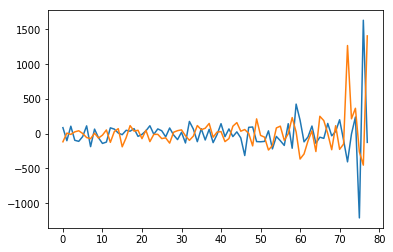

In [16]:
for i in range(2):
    pl.plot(PCA_features[i])

In [17]:
# PCA is isometry
# <Ux, Ux> = <x, x>

for _ in range(10):
    i, j = np.random.choice(len(train), 2, replace=False)
    dist_spat = np.sum(np.square(train_centered[i]-train_centered[j]))
    dist_feat = np.sum(np.square(PCA_features[i]-PCA_features[j]))

    print(dist_spat, dist_feat, dist_spat >= dist_feat)

(6337074.0, 5598748.0, True)
(3570085.0, 3063468.0, True)
(4112295.0, 3525568.8, True)
(2905316.0, 2206065.2, True)
(6084143.0, 5042720.0, True)
(7290582.0, 6437891.0, True)
(11672481.0, 10958586.0, True)
(10408081.0, 10011247.0, True)
(12983008.0, 12120112.0, True)
(10570244.0, 9312101.0, True)


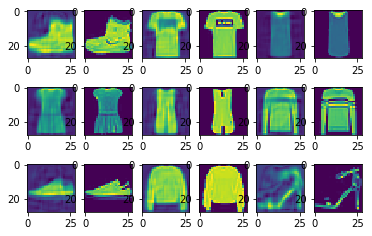

In [18]:
reconstruct = PCA_features.dot(base.T)+np.mean(train_flatten, axis=0)
for i in range(9):
    
    pl.subplot(3, 6, 2*i+1)
    rec = reconstruct[i]
    pl.imshow(rec.reshape((28, 28)))
    
    pl.subplot(3, 6, 2*i+2)
    pl.imshow(train[i])
    

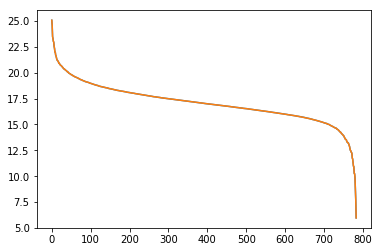

In [19]:
# Y   = U*S*Vt
# YYt = U*S*Vt*V*St*Ut = U S^2 Ut
U, S, V = np.linalg.svd(train_centered.T, full_matrices=False)

pl.plot(np.log(S**2))
pl.plot(np.log(eigvals[::-1]))

('mem gpu', 0.02898097038269043)
('cnt gpu', 0.4254288673400879)
('cov gpu', 0.0009520053863525391)
('svd gpu', 1.6014859676361084)


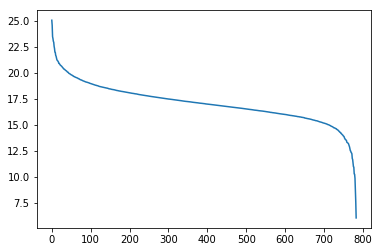

In [20]:
################################################################################
# make it really fast
################################################################################

# here we use a GeForce GT 750M with 
#  - 2GB of GDDR5 RAM @ 64.19 GB/s 
#  - 742.7 GFLOPS FP32 performance

# typically you would use a Tesla V100 
#  - 16 GB of HBM2 RAM @ 920 GB/s
#  - 15.7 TFLOPS FP32 performance 

# use the latest version directly from github
# pip install --user git+git://github.com/lebedov/scikit-cuda

import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.linalg as linalg
import skcuda.misc as misc

linalg.init()

begin = time.time()
X_gpu = gpuarray.to_gpu(train_flatten)
print("mem gpu", time.time()-begin)

begin = time.time()
M_gpu = misc.mean(X_gpu, axis=0, keepdims=True)
X_gpu = misc.subtract(X_gpu, M_gpu)
print("cnt gpu", time.time()-begin)

begin = time.time()
C_gpu = linalg.dot(X_gpu, X_gpu, "T", "N")
print("cov gpu", time.time()-begin)

begin = time.time()
U_gpu, S_gpu, V_gpu = linalg.svd(C_gpu) 
print("svd gpu", time.time()-begin)

S = S_gpu.get()

pl.plot(np.log(S))
